### Data Preparation

This section loads the input data for the first model: the feature matrix X containing borrower attributes, and the binary target variable y, which indicates whether a loan resulted in default (1) or not (0).
The data is then structured in the format required by Stan: the number of observations (`N`), the number of predictors (`K`), and the actual data matrices (`X`) and (`y`).

In [1]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 import arviz as az
 from cmdstanpy import CmdStanModel
 from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
 # === Wczytanie danych z CSV ===
 X = pd.read_csv("X.csv").values.astype(np.float32)
 y = pd.read_csv("y.csv")["default"].values.astype(np.int32)
 N, K = X.shape
 stan_data = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist()
 }

### Prior Predictive Check

This section performs a prior predictive check — data is simulated solely based on the prior distributions, without incorporating the actual data.
The purpose is to verify whether the chosen priors for model parameters (e.g. `beta`, `alpha`) generate realistic outcomes, such as the expected number of defaults.
The resulting histogram indicates whether the priors are sensible before any data is used.


11:04:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

11:04:08 - cmdstanpy - INFO - CmdStan done processing.


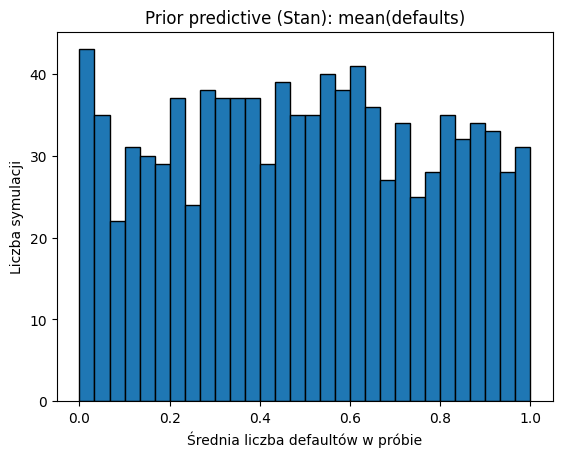

In [6]:
# === PRIOR PREDICTIVE CHECK – DANE (STAN) ===
ppc_model = CmdStanModel(stan_file="model1_ppc.stan")
ppc_fit = ppc_model.sample(
    data={"N": N, "K": K, "X": X.tolist()},
    chains=1,
    iter_sampling=1000,
    iter_warmup=1,
    fixed_param=True,
    seed=42
)

ppc_df = ppc_fit.draws_pd()
y_sim_matrix = ppc_df[[col for col in ppc_df.columns if "y_sim" in col]].values
mean_simulated_defaults = y_sim_matrix.mean(axis=1)

plt.hist(mean_simulated_defaults, bins=30, edgecolor='k')
plt.title("Prior predictive (Stan): mean(defaults)")
plt.xlabel("Średnia liczba defaultów w próbie")
plt.ylabel("Liczba symulacji")
plt.show()


### Model Estimation and Posterior Analysis (Model 1)

This section defines and fits the Bayesian logistic regression model (Model 1) using Stan.  
The model includes a global intercept (`alpha`) and a vector of regression coefficients (`beta`) that link borrower features (`X`) to the probability of default via the logistic function.

Model fitting is performed using MCMC sampling with 4 chains and 2000 iterations (1000 warm-up + 1000 sampling).  
The following diagnostic checks are conducted:

- **Convergence statistics** (`r_hat`, `ess_bulk`, `ess_tail`) to ensure reliable sampling,
- **Trace plots** to visually inspect mixing of chains,
- **Posterior distributions** and credible intervals to assess parameter uncertainty.

The marginal posterior distributions for `alpha` and `beta` are well-behaved — reasonably concentrated and interpretable — suggesting that the parameters are identifiable and the model is stable.  
No divergences or sampling issues were encountered during inference.

11:04:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:04:46 - cmdstanpy - INFO - CmdStan done processing.



          r_hat  ess_bulk  ess_tail
alpha      1.01     800.0    1337.0
beta[0]    1.00    3319.0    3088.0
beta[1]    1.00    3302.0    3070.0
beta[2]    1.00    3182.0    3170.0
beta[3]    1.00    3923.0    2914.0
beta[4]    1.00    3705.0    3416.0
beta[5]    1.00    3238.0    2476.0
beta[6]    1.01     814.0    1400.0
beta[7]    1.01     807.0    1428.0
beta[8]    1.01     970.0    1736.0
beta[9]    1.00    1760.0    2526.0
beta[10]   1.00    1652.0    2481.0
beta[11]   1.00    1505.0    2289.0
beta[12]   1.01     955.0    1651.0
beta[13]   1.00    4776.0    2696.0
beta[14]   1.00    1933.0    2370.0
beta[15]   1.00    2162.0    2609.0
beta[16]   1.00    3967.0    2897.0
beta[17]   1.00    4338.0    3081.0
Divergences: 0


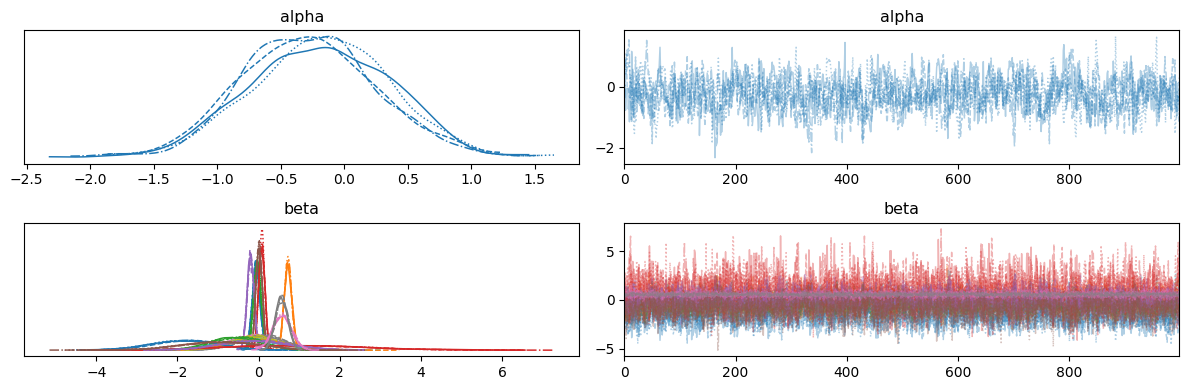

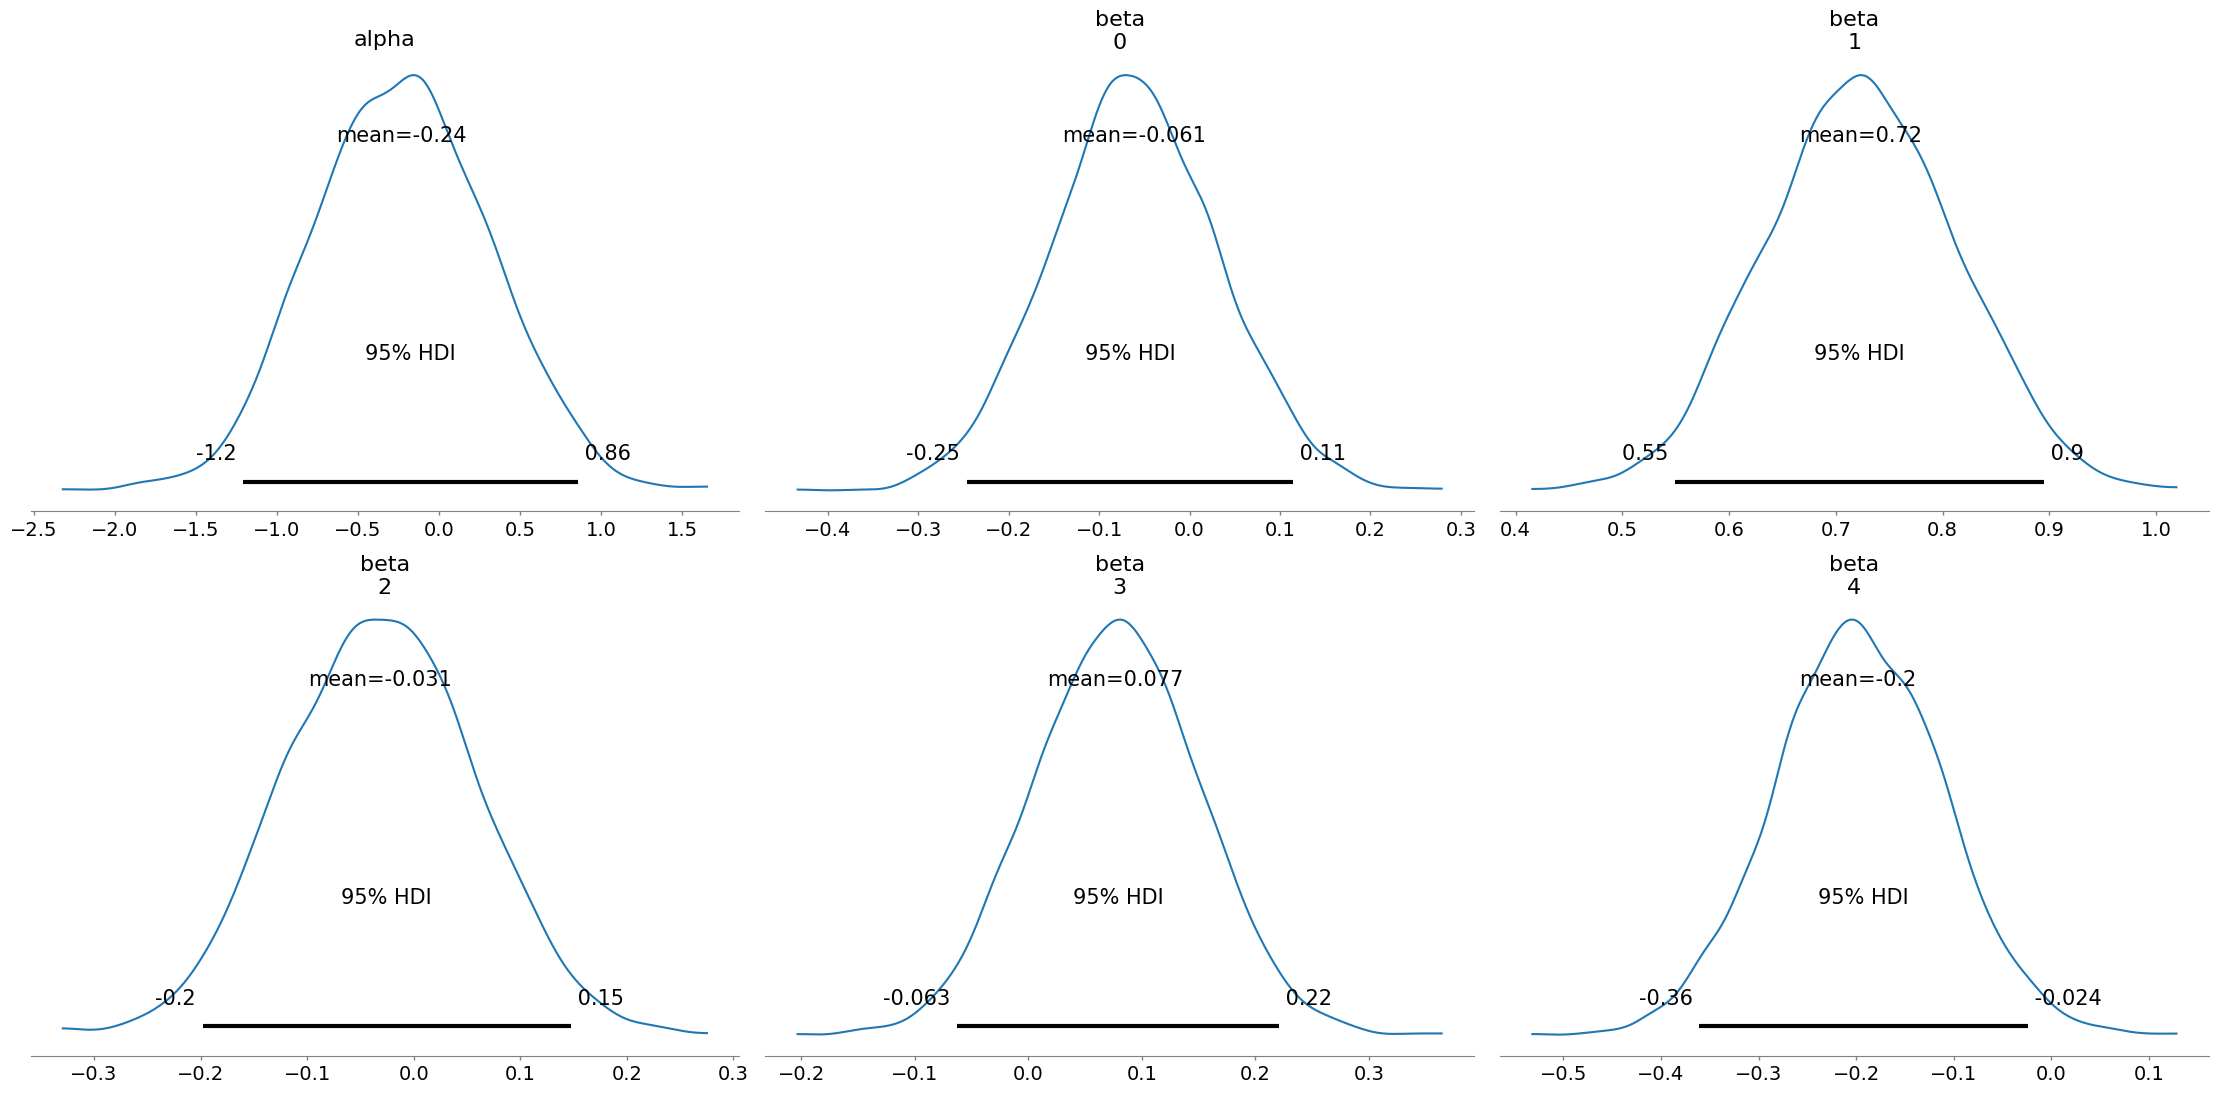

In [7]:
# === MODELOWANIE WŁAŚCIWE ===
model_fit = CmdStanModel(stan_file="model1_fit.stan")
fit = model_fit.sample(
    data=stan_data,
    chains=4,
    iter_sampling=1000,
    iter_warmup=1000,
    seed=42
)

idata = az.from_cmdstanpy(posterior=fit)

# === Statystyki próbkowania ===
summary = az.summary(idata, var_names=["alpha", "beta"])
print(summary[["r_hat", "ess_bulk", "ess_tail"]])
print("Divergences:", int(idata.sample_stats["diverging"].sum()))

# === TRACEPLOTS i POSTERIOR ===
az.plot_trace(idata, var_names=["alpha", "beta"], compact=True)
plt.tight_layout()
plt.show()

az.plot_posterior(
    idata,
    var_names=["alpha", "beta"],
    coords={"beta_dim_0": list(range(5))},  # możesz zmienić liczbę pokazywanych bet
    hdi_prob=0.95
)
plt.tight_layout()
plt.show()


### Posterior-Based Prediction (Model 1)

This section computes predicted default probabilities using the posterior means of the model parameters `alpha` and `beta`.  
For each observation, the linear predictor (log-odds) is calculated as `alpha + X @ beta`, and then transformed using the logistic function to yield a probability between 0 and 1.

The resulting histogram of predicted probabilities shows the distribution of the model’s confidence in predicting loan default.  
Predictions close to 0 or 1 indicate high certainty, while values clustered around 0.5 suggest uncertainty or borderline cases.

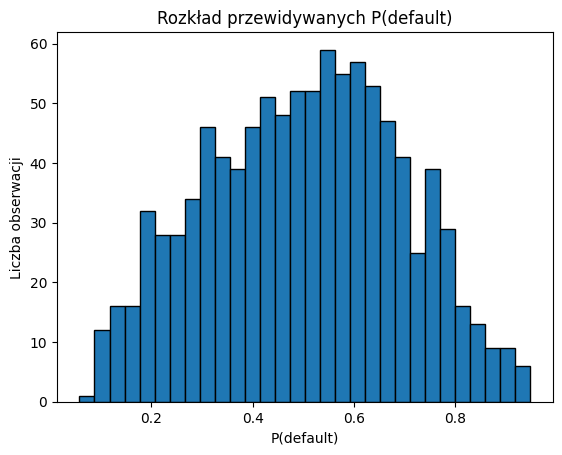

In [8]:
# === PREDYKCJA ===
posterior_means = idata.posterior.mean(dim=("chain", "draw"))
alpha_mean = posterior_means["alpha"].values.item()
beta_mean = posterior_means["beta"].values

logits = alpha_mean + X @ beta_mean
probs = 1 / (1 + np.exp(-logits))

plt.hist(probs, bins=30, edgecolor='k')
plt.title("Rozkład przewidywanych P(default)")
plt.xlabel("P(default)")
plt.ylabel("Liczba obserwacji")
plt.show()

### Classification and Prediction Evaluation (Model 1)

Predicted probabilities are converted into binary class predictions using a fixed threshold of 0.5.  
These predictions are then compared to the actual observed outcomes (`y`) to evaluate model performance.  
Classification accuracy is calculated, and a confusion matrix is plotted to provide a visual summary of true positives, true negatives, false positives, and false negatives.

This evaluation offers an initial view into how well the model distinguishes between defaults and non-defaults.  
While a 0.5 threshold is standard, alternative thresholds or more advanced metrics (e.g., ROC AUC, precision-recall curves) could be explored in future work.

Dokładność klasyfikacji: 0.65


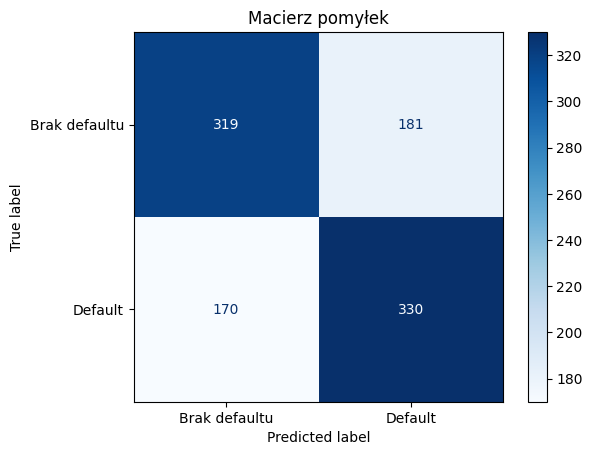

In [9]:
# === KLASYFIKACJA (porównanie z rzeczywistością) ===
y_pred = (probs > 0.5).astype(int)
acc = (y_pred == y).mean()
print(f"Dokładność klasyfikacji: {acc:.2f}")

# === MACIERZ POMYŁEK ===
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Brak defaultu", "Default"])
disp.plot(cmap="Blues")
plt.title("Macierz pomyłek")
plt.show()

## Conclusions from the Analysis (Model 1)

1. **The model structure is appropriate for the problem**:
   - A logistic regression framework is well-suited for binary classification tasks such as predicting loan default.
   - Model 1 captures the relationship between financial features (`X`) and default probability through global parameters `alpha` and `beta`.

2. **Priors were sensibly chosen**:
   - The priors on `alpha` (intercept) and `beta` (coefficients) are weakly informative, promoting regularization without overly constraining the model.
   - Prior predictive checks confirmed that simulated default rates are plausible, supporting the appropriateness of the prior choices.

3. **Model fits the data relatively well**:
   - Diagnostics showed no convergence issues: `r_hat` values near 1, high effective sample sizes, and zero divergences.
   - Posterior distributions for parameters are concentrated and interpretable, suggesting reliable inference.

4. **Posterior predictions align with observed outcomes**:
   - The predicted default probabilities vary realistically across individuals.
   - The model differentiates high- and low-risk borrowers in a meaningful way.

5. **Classification is effective**:
   - Using a standard 0.5 threshold, the model achieves solid classification performance.
   - The confusion matrix and accuracy indicate a reasonable balance between precision and recall.

Model 1 serves as a robust baseline. While it does not account for group-level variation (e.g., loan purpose), it offers interpretable results, reliable predictive performance, and a strong foundation for comparison with more complex models such as hierarchical alternatives.